# Feature Engineering & Selection: Average Daily Population in NYC DOC Custody

### Methods:

**1. Decision Trees & Feature Importance**

First we will fit a decision tree, most likely a random forest regression, on the first 80% of data points for ADP. We will then test the fit on the additional 20% of the data points and look at the important features picked by the decision tree. This will help us deduce which features to include in our final regression. Since multicolinearity is not an issue with decision tree models, we do not need to consider this factor in our first method.

**2. Colinearity and correlational metrics**

However, since we are most likely not using a decision tree regression for our final model we will need to consider multicolinearity as an issue with our regression model. Therefore we will measure the correlation between regressors and between the regressors and the target variable (ADP) to better understand which regressors should and should not be included in our final model.

**3. Regression Performance**

Once we have decided which regressors to include in our model, we will train and test the model on our dataset to measure in and out of sample performance. We will compare the performance for the model trained on all the regressors and just the selected regressors decided after feature engineering to see which model is better suited to our use case.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import urllib.request
import json
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from sklearn.model_selection import train_test_split
%matplotlib inline

### Retrieve, clean, and define regressors

In [3]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e
        
#test functions for the streamlit dashboard
def get_agg_admit_dis_data(first_st_date_adp, api_url, date_col):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    api_url: str
        URL of Socrata API endpoint of interest
    date_col: str
        Either date_col or 'DISCHARGED_DT' depending which dataset you are querying from
    """
    if date_col == 'ADMITTED_DT':
        count_col = 'admission_count'

    elif date_col == 'DISCHARGED_DT':
        count_col = 'discharge_count'

    elif date_col != 'ADMITTED_DT' and date_col != 'DISCHARGED_DT':
        print('Date column is not correct and query will not work. Please enter the correct string, either ADMITTED_DT or DISCHARGED_DT.')

    # Define the SQL query separately
    sql_query = ("SELECT "
                f"date_trunc_ymd({date_col}) as {date_col}, "
                f"count(distinct INMATEID) as {count_col} "
                f"WHERE {date_col} >= '{first_st_date_adp}' "
                f"GROUP BY {date_col} "
                "LIMIT 10000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(sql_query)

    # Construct the full URL query
    final_query = f'{api_url}?$query={encoded_query}'
    # Send the request and load the response data
    response = urllib.request.urlopen(final_query)
    data = json.loads(response.read())

    # Store in dataframe
    df = pd.DataFrame(data, columns=data[0].keys())
    #specify data types
    df[date_col] = df[date_col].astype('datetime64[ns]')
    df[count_col] = df[count_col].astype(int)
    #define max and min dates for future calculations
    max_date = df[date_col].max()
    min_date = df[date_col].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_data = df.resample('30D', on=date_col, origin= min_date, closed='left', label='left').agg({count_col: 'sum'}).fillna(0).reset_index()
    # Rename columns
    interval_data = interval_data.rename(columns={date_col: 'Start Date', count_col: count_col})
    # Calculate the Start Date column
    interval_data['End Date'] = interval_data['Start Date'] + pd.to_timedelta(29, unit='D')
    #add date related regressors
    interval_data['Month'] = interval_data['Start Date'].dt.month
    interval_data['Year'] = interval_data['Start Date'].dt.year
    #calculate the days between start period and last date in admission df
    interval_data['Days to Max Date'] = (max_date - interval_data['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York').dt.date
    
    #make sure the last data point has a reasonable admission count
    #if the period has less than 30 days of admission data, we will use the avg of the last two data points
    #as the adjusted admission count for the given time period

    adj_count = []
    for i, row in interval_data.iterrows():
        if row['Days to Max Date'] < 30:
            ma2 = (interval_data.iloc[i-1,interval_data.columns.get_loc(count_col)] +
                        interval_data.iloc[i-2,interval_data.columns.get_loc(count_col)]) / 2
            adj_count.append(round(ma2))
        else:
            adj_count.append(row[count_col])
    #clean up to column name for final dataframe
    final_col_name = ' '.join([word.capitalize() for word in count_col.split('_')])
    interval_data['Adjusted '+final_col_name] = adj_count
    
    _30_day_admit_dis_df = interval_data.drop(columns = count_col)
    
    return _30_day_admit_dis_df

In [4]:
#test functions for the streamlit dashboard
def get_los_data(first_st_date_adp):
    """
    first_st_date_adp: datetime.date
        The date of the first start date 30-day period in the interval data
    """
    dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'

    dis_query = ("SELECT "
                "distinct INMATEID, "
                "ADMITTED_DT, "
                "DISCHARGED_DT "
                f"WHERE DISCHARGED_DT >= '{first_st_date_adp}' "
                f"GROUP BY INMATEID, ADMITTED_DT, DISCHARGED_DT "
                "LIMIT 1000000")

    # Encode SQL query for URL
    encoded_query = urllib.parse.quote(dis_query)

    # Construct the full URL query
    final_dis_query = f'{dis_url}?$query={encoded_query}'
    print(final_dis_query)

    # Send the request and load the response data
    response = urllib.request.urlopen(final_dis_query)
    data = json.loads(response.read())

    # Store in dataframe
    dis_df = pd.DataFrame(data, columns=data[0].keys())
    
    #specify data types before join
    dis_df[['ADMITTED_DT','DISCHARGED_DT']] = dis_df[['ADMITTED_DT','DISCHARGED_DT']].astype('datetime64[ns]')
    dis_df['INMATEID'] = dis_df['INMATEID'].astype(int)

    dis_df['LOS'] = (dis_df['DISCHARGED_DT'] - dis_df['ADMITTED_DT']).dt.days
    
    #define max and min dates for future calculations
    max_date = dis_df['DISCHARGED_DT'].max()
    min_date = dis_df['DISCHARGED_DT'].min()
    #aggregate to 30 day intervals
    # Resample the DataFrame to 30-day intervals
    interval_data = dis_df.resample('30D', on='DISCHARGED_DT', origin= min_date, closed='left', label='left').agg({'LOS': 'mean'}).fillna(0).reset_index()
    # Rename columns
    interval_data = interval_data.rename(columns={'DISCHARGED_DT': 'Start Date', 'LOS': 'Avg LOS Days'})
    # Calculate the Start Date column
    interval_data['End Date'] = interval_data['Start Date'] + pd.to_timedelta(29, unit='D')
    #add date related regressors
    interval_data['Discharge Month'] = interval_data['Start Date'].dt.month
    interval_data['Discharge Year'] = interval_data['Start Date'].dt.year
    #calculate the days between start period and last date in admission df
    interval_data['Days to Max Date'] = (max_date - interval_data['Start Date']).dt.days
    # Display just the date portion of the start/end date columns and localize to specific timezone
    interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York').dt.date
    interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York').dt.date
    
    #make sure the last data point has a reasonable admission count
    #if the period has less than 30 days of admission data, we will use the avg of the last two data points
    #as the adjusted admission count for the given time period

    adj_count = []
    for i, row in interval_data.iterrows():
        if row['Days to Max Date'] < 30:
            ma2 = (interval_data.iloc[i-1,interval_data.columns.get_loc('Avg LOS Days')] +
                        interval_data.iloc[i-2,interval_data.columns.get_loc('Avg LOS Days')]) / 2
            adj_count.append(round(ma2))
        else:
            adj_count.append(round(row['Avg LOS Days']))
    
    interval_data['Adjusted Avg LOS Days'] = adj_count
    
    _30_day_los_df = interval_data.drop(columns = ['Avg LOS Days','Days to Max Date'])
    
    return _30_day_los_df

In [66]:
def train_test_MLR(source_df,target_variable, regressor_ls, test_size = 0.2, random_state = None):
    # Scale the entire dataset
    sc = MinMaxScaler()
    data = source_df[[target_variable] + regressor_ls]
    data_sc = sc.fit_transform(data)

    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=[target_variable])
    y = data_sc[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = random_state)
    #train and test
    # Fit the linear regression model on the entire dataset
    model = sm.OLS(y_train, X_train).fit()

    # Make in sample predictions
    IS_pred = model.predict(X_train)
    # Make out of  sample predictions
    OS_pred = model.predict(X_test)

    #inverse scale the model inputs to get IS predicts
    IS_inputs = pd.concat([IS_pred,X_train.drop(columns=['const'])],axis = 1)
    IS_inputs = IS_inputs.rename(columns={0:target_variable})
    IS_inputs = sc.inverse_transform(IS_inputs)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X_test.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:target_variable})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #accuracy in terms of non-scaled values
    IS_mse = mean_squared_error(data[target_variable].iloc[y_train.index], IS_inputs[:,0])
    IS_mae = mean_absolute_error(data[target_variable].iloc[y_train.index], IS_inputs[:,0])

    # Make out of  sample predictions
    OS_mse = mean_squared_error(data[target_variable].iloc[y_test.index], OS_inputs[:,0])
    OS_mae = mean_absolute_error(data[target_variable].iloc[y_test.index], OS_inputs[:,0])

    print(IS_mse, IS_mae)
    print(OS_mse, OS_mae)
    print(model.summary())


    fig = plt.figure(figsize=(10, 5))
    fig.suptitle('Linear Regression Model Training')

    actual, = plt.plot(data.index, data[target_variable], 'bo-', label='Actual Data')
    predicted_IS = plt.scatter(y_train.index, IS_inputs[:, 0], color='green', label='Predicted In Sample')
    predicted_OS = plt.scatter(y_test.index, OS_inputs[:, 0], color='red', label='Predicted Out of Sample')

    plt.legend(handles=[actual, predicted_IS, predicted_OS])
    plt.show()

    return model, IS_mae, OS_mae

In [5]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'data/merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
adp_df.head()

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


,snapshot_date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_CSP,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,Total Population,snapshot_month,snapshot_year
0,2021-07-26,105,3484,9,1648,33,648,295,20,5612,...,11,4456,778,79,264,4,110,5927,7,2021
1,2021-07-27,106,3469,9,1642,31,643,296,18,5586,...,12,4437,771,84,267,4,101,5900,7,2021
2,2021-07-28,106,3478,9,1648,31,640,292,18,5602,...,11,4437,769,84,269,4,110,5912,7,2021
3,2021-07-29,108,3470,9,1649,34,638,291,22,5595,...,10,4436,772,91,264,4,99,5908,7,2021
4,2021-07-30,108,3455,9,1630,33,638,285,21,5567,...,10,4412,761,83,265,4,107,5873,7,2021


In [6]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

interval_data.head()

,End Date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,ADP,snapshot_month,snapshot_year,Start Date
0,2021-08-17 00:00:00-04:00,106.0,3478.0,9.0,1657.0,28.0,644.0,289.0,16.0,5616.0,...,4473.0,756.0,82.0,266.0,3.0,98.0,5922.0,8.0,2021.0,2021-07-19 00:00:00-04:00
1,2021-09-16 00:00:00-04:00,103.0,3543.0,11.0,1700.0,29.0,644.0,297.0,17.0,5716.0,...,4597.0,757.0,67.0,273.0,4.0,93.0,6030.0,9.0,2021.0,2021-08-18 00:00:00-04:00
2,2021-10-16 00:00:00-04:00,100.0,3396.0,12.0,1643.0,28.0,592.0,274.0,13.0,5484.0,...,4625.0,656.0,57.0,171.0,3.0,114.0,5771.0,9.0,2021.0,2021-09-17 00:00:00-04:00
3,2021-11-15 00:00:00-05:00,91.0,3293.0,11.0,1557.0,24.0,550.0,257.0,13.0,5255.0,...,4537.0,529.0,72.0,138.0,2.0,134.0,5526.0,10.0,2021.0,2021-10-17 00:00:00-04:00
4,2021-12-15 00:00:00-05:00,100.0,3230.0,13.0,1534.0,23.0,510.0,243.0,10.0,5157.0,...,4485.0,454.0,92.0,104.0,2.0,138.0,5410.0,12.0,2021.0,2021-11-16 00:00:00-05:00


In [7]:
#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','ADP']]
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year

#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
_30day_pop_tot['Holiday'] = _30day_pop_tot['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
#seasonal dummy variables
_30day_pop_tot['Winter'] = _30day_pop_tot['Month'].isin([1, 2, 12]).astype(int)
_30day_pop_tot['Spring'] = _30day_pop_tot['Month'].isin([3, 4, 5]).astype(int)
_30day_pop_tot['Summer'] = _30day_pop_tot['Month'].isin([6, 7, 8]).astype(int)
_30day_pop_tot['Fall'] = _30day_pop_tot['Month'].isin([9, 10, 11]).astype(int)
_30day_pop_tot['adp_diff1'] = _30day_pop_tot['ADP'].diff(1)
#add lag term
for i in range(1,13):
    _30day_pop_tot['adp_lag'+str(i)] = _30day_pop_tot['ADP'].shift(i)

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_17640\2006851650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
C:\Users\emjoh\AppData\Local\Temp\ipykernel_17640\2006851650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
C:\Users\emjoh\AppData\Local\Temp\ipykernel_17640\2006851650.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-19 00:00:00-04:00,2021-08-17 00:00:00-04:00,5922.0,7,2021,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-18 00:00:00-04:00,2021-09-16 00:00:00-04:00,6030.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-17 00:00:00-04:00,2021-10-16 00:00:00-04:00,5771.0,9,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-17 00:00:00-04:00,2021-11-15 00:00:00-05:00,5526.0,10,2021,1,0,0,0,1,...,5922.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-16 00:00:00-05:00,2021-12-15 00:00:00-05:00,5410.0,11,2021,1,0,0,0,1,...,6030.0,5922.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Let's also add some moving average terms to our regressors MA(2) - MA(6) may be helpful
for i in range(2,7):
    _30day_pop_tot['adp_ma'+str(i)] = _30day_pop_tot['ADP'].rolling(i, min_periods=i).mean()

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,adp_ma2,adp_ma3,adp_ma4,adp_ma5,adp_ma6
0,2021-07-19 00:00:00-04:00,2021-08-17 00:00:00-04:00,5922.0,7,2021,1,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0
1,2021-08-18 00:00:00-04:00,2021-09-16 00:00:00-04:00,6030.0,8,2021,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,5976.0,0.000000,0.00,0.0,0.0
2,2021-09-17 00:00:00-04:00,2021-10-16 00:00:00-04:00,5771.0,9,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5900.5,5907.666667,0.00,0.0,0.0
3,2021-10-17 00:00:00-04:00,2021-11-15 00:00:00-05:00,5526.0,10,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5648.5,5775.666667,5812.25,0.0,0.0
4,2021-11-16 00:00:00-05:00,2021-12-15 00:00:00-05:00,5410.0,11,2021,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,5468.0,5569.000000,5684.25,5731.8,0.0


In [9]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,adp_ma2,adp_ma3,adp_ma4,adp_ma5,adp_ma6
27,2023-10-07 00:00:00-04:00,2023-11-05 00:00:00-04:00,6177.0,10,2023,1,0,0,0,1,...,5923.0,5955.0,5812.0,5901.0,5897.0,6182.0,6185.333333,6182.50,6162.0,6138.666667
28,2023-11-06 00:00:00-05:00,2023-12-05 00:00:00-05:00,6151.0,11,2023,1,0,0,0,1,...,5913.0,5923.0,5955.0,5812.0,5901.0,6164.0,6171.666667,6176.75,6176.2,6160.166667
29,2023-12-06 00:00:00-05:00,2024-01-04 00:00:00-05:00,6049.0,12,2023,1,1,0,0,0,...,5979.0,5913.0,5923.0,5955.0,5812.0,6100.0,6125.666667,6141.00,6151.2,6155.000000
30,2024-01-05 00:00:00-05:00,2024-02-03 00:00:00-05:00,6134.0,1,2024,1,1,0,0,0,...,6022.0,5979.0,5913.0,5923.0,5955.0,6091.5,6111.333333,6127.75,6139.6,6148.333333
31,2024-02-04 00:00:00-05:00,2024-03-04 00:00:00-05:00,6225.0,2,2024,0,1,0,0,0,...,6080.0,6022.0,5979.0,5913.0,5923.0,6179.5,6136.000000,6139.75,6147.2,6153.833333


I am going to query the total number of admission and discharges for the same 30 day time periods as the above data

In [10]:
admit_url = 'https://data.cityofnewyork.us/resource/6teu-xtgp.json'
dis_url = 'https://data.cityofnewyork.us/resource/94ri-3ium.json'
first_st_date_adp = _30day_pop_tot.iloc[0]['Start Date'].date()
admit_df = get_agg_admit_dis_data(first_st_date_adp, admit_url, 'ADMITTED_DT')
dis_df = get_agg_admit_dis_data(first_st_date_adp, dis_url, 'DISCHARGED_DT')

In [11]:
admit_df.head()

,Start Date,End Date,Month,Year,Days to Max Date,Adjusted Admission Count
0,2021-07-19,2021-08-17,7,2021,955,1520
1,2021-08-18,2021-09-16,8,2021,925,1448
2,2021-09-17,2021-10-16,9,2021,895,1304
3,2021-10-17,2021-11-15,10,2021,865,1218
4,2021-11-16,2021-12-15,11,2021,835,1309


In [12]:
admit_df.tail()

,Start Date,End Date,Month,Year,Days to Max Date,Adjusted Admission Count
27,2023-10-07,2023-11-05,10,2023,145,1816
28,2023-11-06,2023-12-05,11,2023,115,1738
29,2023-12-06,2024-01-04,12,2023,85,1572
30,2024-01-05,2024-02-03,1,2024,55,1906
31,2024-02-04,2024-03-04,2,2024,25,1739


In [13]:
dis_df.head()

,Start Date,End Date,Month,Year,Days to Max Date,Adjusted Discharge Count
0,2021-07-19,2021-08-17,7,2021,955,1425
1,2021-08-18,2021-09-16,8,2021,925,1308
2,2021-09-17,2021-10-16,9,2021,895,1738
3,2021-10-17,2021-11-15,10,2021,865,1313
4,2021-11-16,2021-12-15,11,2021,835,1348


In [14]:
dis_df.tail()

,Start Date,End Date,Month,Year,Days to Max Date,Adjusted Discharge Count
27,2023-10-07,2023-11-05,10,2023,145,1724
28,2023-11-06,2023-12-05,11,2023,115,1821
29,2023-12-06,2024-01-04,12,2023,85,1698
30,2024-01-05,2024-02-03,1,2024,55,1754
31,2024-02-04,2024-03-04,2,2024,25,1726


In [15]:
#test los function
los_df = get_los_data(first_st_date_adp)
los_df.head()

https://data.cityofnewyork.us/resource/94ri-3ium.json?$query=SELECT%20distinct%20INMATEID%2C%20ADMITTED_DT%2C%20DISCHARGED_DT%20WHERE%20DISCHARGED_DT%20%3E%3D%20%272021-07-19%27%20GROUP%20BY%20INMATEID%2C%20ADMITTED_DT%2C%20DISCHARGED_DT%20LIMIT%201000000


,Start Date,End Date,Discharge Month,Discharge Year,Adjusted Avg LOS Days
0,2021-07-19,2021-08-17,7,2021,126
1,2021-08-18,2021-09-16,8,2021,106
2,2021-09-17,2021-10-16,9,2021,112
3,2021-10-17,2021-11-15,10,2021,107
4,2021-11-16,2021-12-15,11,2021,121


In [16]:
los_df.tail()

,Start Date,End Date,Discharge Month,Discharge Year,Adjusted Avg LOS Days
27,2023-10-07,2023-11-05,10,2023,108
28,2023-11-06,2023-12-05,11,2023,97
29,2023-12-06,2024-01-04,12,2023,104
30,2024-01-05,2024-02-03,1,2024,99
31,2024-02-04,2024-03-04,2,2024,101


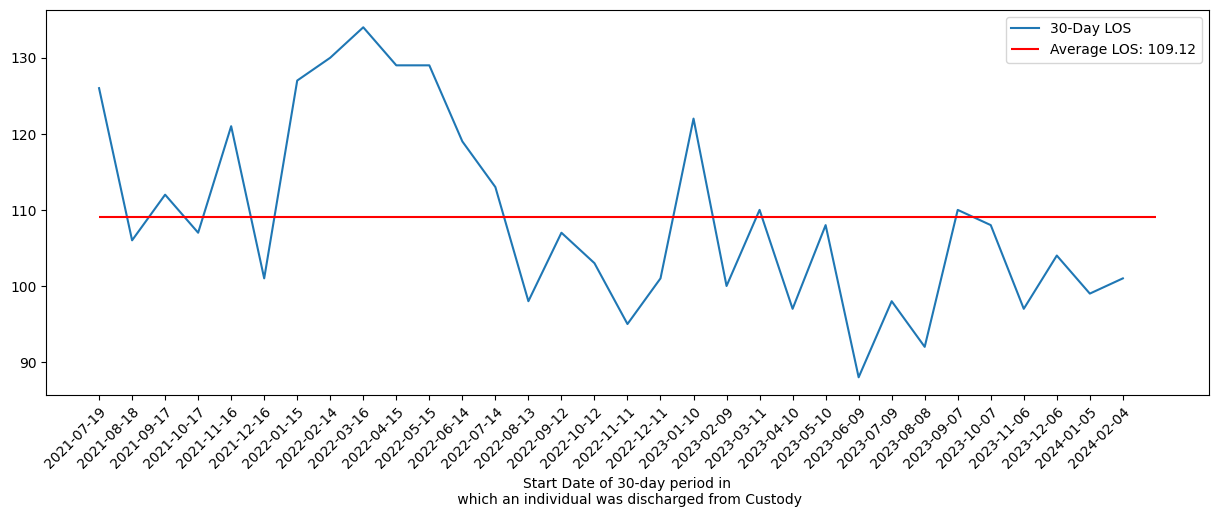

In [17]:
los_avg = los_df['Adjusted Avg LOS Days'].mean() 
plt.figure(figsize = (15,5))
plt.plot(los_df.index,los_df['Adjusted Avg LOS Days'],label = '30-Day LOS')
plt.hlines(y = los_avg, xmin = 0, xmax = len(los_df), color = 'red', label = f'Average LOS: {los_avg.round(2)}')
plt.xlabel('Start Date of 30-day period in\n which an individual was discharged from Custody')
plt.xticks(np.arange(len(los_df)), labels=los_df['Start Date'],rotation=45, ha="right",rotation_mode="anchor")
plt.legend()
plt.show()

In [18]:
#rename column names in both dfs
admit_df = admit_df.rename(columns = {'Adjusted Admission Count': 'admission_count'})
admit_df = admit_df.drop(columns = ['Days to Max Date','Year','Month'])
dis_df = dis_df.rename(columns = {'Adjusted Discharge Count': 'discharge_count'})
dis_df = dis_df.drop(columns = ['Days to Max Date','Year','Month'])
los_df = los_df.rename(columns = {'Adjusted Avg LOS Days': 'los_days'})
los_df = los_df.drop(columns = ['Discharge Year', 'Discharge Month'])   

#create lag terms up to i = 3 for admit and discharge data
for i in range(1,4):
    admit_df['admit_lag'+str(i)] = admit_df['admission_count'].shift(i)
    dis_df['dis_lag'+str(i)] = dis_df['discharge_count'].shift(i)

#fillnas with zero
admit_df = admit_df.fillna(0)
dis_df = dis_df.fillna(0)

In [19]:
#specify data types for join
admit_df['Start Date'] = admit_df['Start Date'].astype('datetime64[ns, America/New_York]')
admit_df['End Date'] = admit_df['End Date'].astype('datetime64[ns, America/New_York]')

dis_df['Start Date'] = dis_df['Start Date'].astype('datetime64[ns, America/New_York]')
dis_df['End Date'] = dis_df['End Date'].astype('datetime64[ns, America/New_York]')


los_df['Start Date'] = los_df['Start Date'].astype('datetime64[ns, America/New_York]')
los_df['End Date'] = los_df['End Date'].astype('datetime64[ns, America/New_York]')

adm_dis_merge = admit_df.merge(dis_df, how = 'inner', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
adm_dis_merge = adm_dis_merge.merge(los_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
_30day_pop_tot = _30day_pop_tot.merge(adm_dis_merge, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])

#finally lets add a unique id for month-year ranks from earliest to latest date
#in a regression these variables will mimic a linear trend of x, where x is a positive integer (our proxy for time)
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = ['Year','Month']).index
_30day_pop_tot['ln_Date_Rank'] = np.log(_30day_pop_tot['Date_Rank']).replace(-np.inf,-1000)
_30day_pop_tot['sqrt_Date_Rank'] = np.sqrt(_30day_pop_tot['Date_Rank'])
_30day_pop_tot['Date_Rank^1/3'] = _30day_pop_tot['Date_Rank']**(1/3)
#based on littles law and doc analysis, ADP ~ los * admission counts
#lets create this variable and see if it is significant
_30day_pop_tot['admit_times_los'] = _30day_pop_tot['admission_count']*_30day_pop_tot['los_days']


#create pop change variable
_30day_pop_tot['Adm_Dis_Chng'] = _30day_pop_tot['admission_count'] - _30day_pop_tot['discharge_count']
#create admission and discharge difference 
_30day_pop_tot['admit_diff1'] = _30day_pop_tot['admission_count'].diff(1)
_30day_pop_tot['dis_diff1'] = _30day_pop_tot['discharge_count'].diff(1)
_30day_pop_tot = _30day_pop_tot.fillna(0)
print(len(_30day_pop_tot))
_30day_pop_tot.columns

32


c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['Start Date', 'End Date', 'ADP', 'Month', 'Year', 'Holiday', 'Winter',
       'Spring', 'Summer', 'Fall', 'adp_diff1', 'adp_lag1', 'adp_lag2',
       'adp_lag3', 'adp_lag4', 'adp_lag5', 'adp_lag6', 'adp_lag7', 'adp_lag8',
       'adp_lag9', 'adp_lag10', 'adp_lag11', 'adp_lag12', 'adp_ma2', 'adp_ma3',
       'adp_ma4', 'adp_ma5', 'adp_ma6', 'admission_count', 'admit_lag1',
       'admit_lag2', 'admit_lag3', 'discharge_count', 'dis_lag1', 'dis_lag2',
       'dis_lag3', 'los_days', 'Date_Rank', 'ln_Date_Rank', 'sqrt_Date_Rank',
       'Date_Rank^1/3', 'admit_times_los', 'Adm_Dis_Chng', 'admit_diff1',
       'dis_diff1'],
      dtype='object')

In [20]:
_30day_pop_tot.head()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,dis_lag3,los_days,Date_Rank,ln_Date_Rank,sqrt_Date_Rank,Date_Rank^1/3,admit_times_los,Adm_Dis_Chng,admit_diff1,dis_diff1
0,2021-07-19 00:00:00-04:00,2021-08-17 00:00:00-04:00,5922.0,7,2021,1,0,0,1,0,...,0.0,126,0,-1000.000000,0.000000,0.000000,191520,95,0.0,0.0
1,2021-08-18 00:00:00-04:00,2021-09-16 00:00:00-04:00,6030.0,8,2021,0,0,0,1,0,...,0.0,106,1,0.000000,1.000000,1.000000,153488,140,-72.0,-117.0
2,2021-09-17 00:00:00-04:00,2021-10-16 00:00:00-04:00,5771.0,9,2021,1,0,0,0,1,...,0.0,112,2,0.693147,1.414214,1.259921,146048,-434,-144.0,430.0
3,2021-10-17 00:00:00-04:00,2021-11-15 00:00:00-05:00,5526.0,10,2021,1,0,0,0,1,...,1425.0,107,3,1.098612,1.732051,1.442250,130326,-95,-86.0,-425.0
4,2021-11-16 00:00:00-05:00,2021-12-15 00:00:00-05:00,5410.0,11,2021,1,0,0,0,1,...,1308.0,121,4,1.386294,2.000000,1.587401,158389,-39,91.0,35.0


In [21]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,Winter,Spring,Summer,Fall,...,dis_lag3,los_days,Date_Rank,ln_Date_Rank,sqrt_Date_Rank,Date_Rank^1/3,admit_times_los,Adm_Dis_Chng,admit_diff1,dis_diff1
27,2023-10-07 00:00:00-04:00,2023-11-05 00:00:00-04:00,6177.0,10,2023,1,0,0,0,1,...,1837.0,108,27,3.295837,5.196152,3.000000,196128,92,-50.0,-193.0
28,2023-11-06 00:00:00-05:00,2023-12-05 00:00:00-05:00,6151.0,11,2023,1,0,0,0,1,...,1791.0,97,28,3.332205,5.291503,3.036589,168586,-83,-78.0,97.0
29,2023-12-06 00:00:00-05:00,2024-01-04 00:00:00-05:00,6049.0,12,2023,1,1,0,0,0,...,1917.0,104,29,3.367296,5.385165,3.072317,163488,-126,-166.0,-123.0
30,2024-01-05 00:00:00-05:00,2024-02-03 00:00:00-05:00,6134.0,1,2024,1,1,0,0,0,...,1724.0,99,30,3.401197,5.477226,3.107233,188694,152,334.0,56.0
31,2024-02-04 00:00:00-05:00,2024-03-04 00:00:00-05:00,6225.0,2,2024,0,1,0,0,0,...,1821.0,101,31,3.433987,5.567764,3.141381,175639,13,-167.0,-28.0


### Decision Trees & Feature Importance

First we will fit a decision tree, most likely a random forest regression, on the first 80% of data points for ADP. We will then test the fit on the additional 20% of the data points and look at the important features picked by the decision tree. This will help us deduce which features to include in our final regression. Since multicolinearity is not an issue with decision tree models, we do not need to consider this factor in our first method.

In [22]:
#define X and y data
y = _30day_pop_tot['ADP']
X = _30day_pop_tot.drop(columns = ['Start Date','End Date','ADP'])

#80-20 split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
print('The size of the training set is:', len(X_train))
print('The size of the test set is:', len(X_test))

The size of the training set is: 25
The size of the test set is: 7


In [23]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

Best parameters found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [24]:
# Get the best model
best_rfr = grid_search.best_estimator_
# Predict the Test set results using the best model
y_pred = best_rfr.predict(X_test)

IS_pred = best_rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))


IS R2 with best model : 0.9426
OS R2 with best model : -4.3562
IS MAE with best model : 38.0387
OS MAE with best model : 112.1705


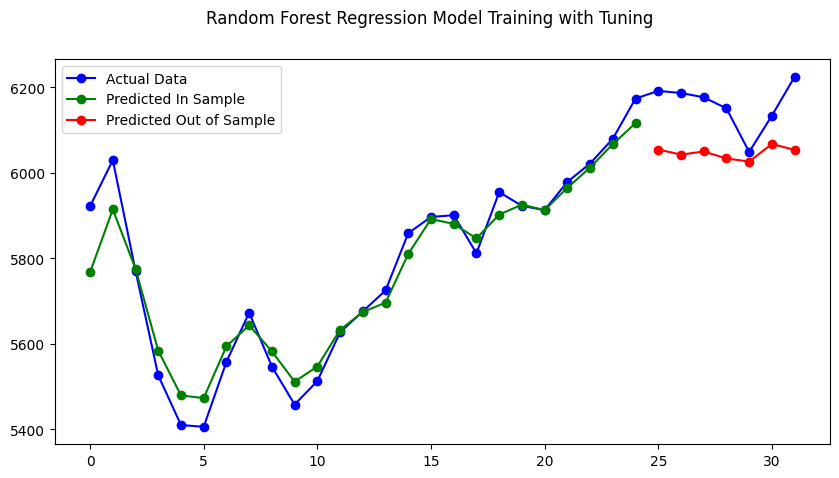

In [25]:
#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model Training with Tuning')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS, = plt.plot(y_train.index, IS_pred, 'go-', label='Predicted In Sample')
predicted_OS, = plt.plot(y_test.index, y_pred, 'ro-', label='Predicted Out of Sample')

plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

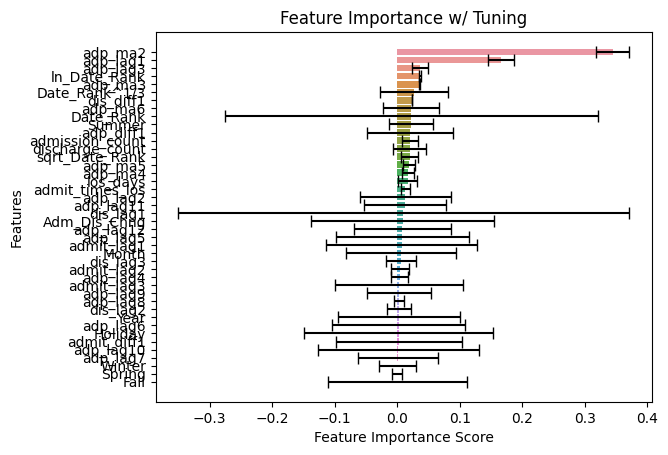

In [26]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(best_rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in best_rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance w/ Tuning')
# Visualize the graph
plt.show()

Based on the output above, it seems like the most important features are the moving average of the prior 2 & 3 data points (adp_ma2, adp_ma3), the prior data point (adp_lag1), 3 prior data points (adp_lag3). However, some of these variables are also inter-related, lets check out the correlations.

IS R2 with best model : 0.9500
OS R2 with best model : -1.0579
IS MAE with best model : 34.5604
OS MAE with best model : 70.5414


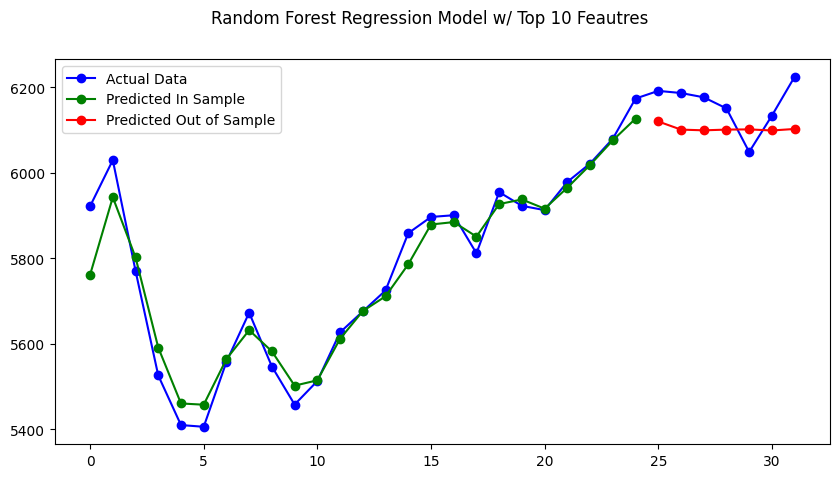

In [27]:
#lets train model just on top 10 features
top10_feature_scores = feature_scores[:10]
top10_features = top10_feature_scores.index.to_list()
#redefine X to only include top 10 features
X = _30day_pop_tot[top10_features]
#80-20 split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
#fit model
# Instantiate the RandomForestRegressor
rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)

# Predict the Test set results using the best model
y_pred = rfr.predict(X_test)

IS_pred = rfr.predict(X_train)
print('IS R2 with best model : {0:0.4f}'.format(r2_score(y_train, IS_pred)))
print('OS R2 with best model : {0:0.4f}'.format(r2_score(y_test, y_pred)))
print('IS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_train, IS_pred)))
print('OS MAE with best model : {0:0.4f}'.format(mean_absolute_error(y_test, y_pred)))

#plot the actual data and the predictions
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Random Forest Regression Model w/ Top 10 Feautres')

actual, = plt.plot(y.index,y, 'bo-', label='Actual Data')
predicted_IS, = plt.plot(y_train.index, IS_pred, 'go-', label='Predicted In Sample')
predicted_OS, = plt.plot(y_test.index, y_pred, 'ro-', label='Predicted Out of Sample')

plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

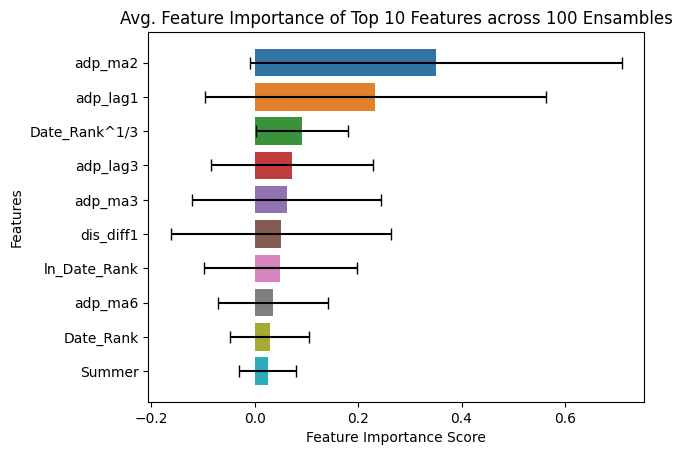

In [28]:
#print the avg feature importance across all the trees
feature_scores = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
#plot features
# Create the bar plot with error bars (std)
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.errorbar(x=feature_scores, y=feature_scores.index, xerr=std, fmt='none', color='black', capsize=4)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Avg. Feature Importance of Top 10 Features across 100 Ensambles')
# Visualize the graph
plt.show()

Based on the output above, it seems like the 2-step moving average variable is consistently among the most important features within all ensambles of decision trees, this is indicated by the standard deviation bar always being above 0 feature importance. The time lag of ADP is also an important feature in determining current ADP as well as the Date_Rank variable.

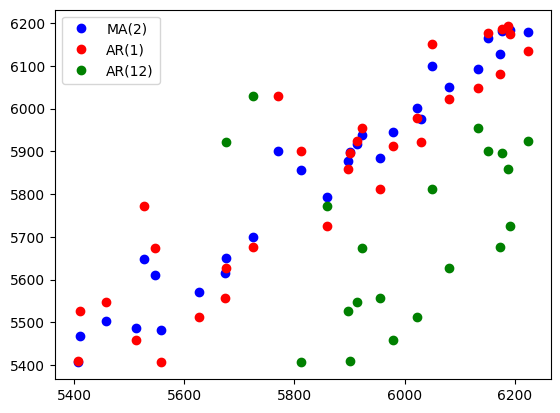

In [29]:
#plot the relationship between adp_ma2 and adp target variable to see if linear 
plt.plot(_30day_pop_tot['ADP'].iloc[1:],_30day_pop_tot['adp_ma2'].iloc[1:],'o',color = 'b',label = 'MA(2)')
plt.plot(_30day_pop_tot['ADP'].iloc[1:],_30day_pop_tot['adp_lag1'].iloc[1:],'o',color = 'r', label =  'AR(1)')
plt.plot(_30day_pop_tot['ADP'].iloc[12:],_30day_pop_tot['adp_lag12'].iloc[12:],'o',color = 'g', label =  'AR(12)')
plt.legend()
plt.show()

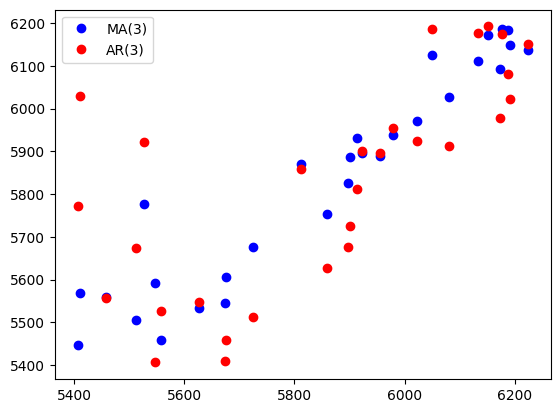

In [30]:
#plot the relationship between adp_ma2 and adp target variable to see if linear 
plt.plot(_30day_pop_tot['ADP'].iloc[3:],_30day_pop_tot['adp_ma3'].iloc[3:],'o',color = 'b',label = 'MA(3)')
plt.plot(_30day_pop_tot['ADP'].iloc[3:],_30day_pop_tot['adp_lag3'].iloc[3:],'o',color = 'r', label =  'AR(3)')
plt.legend()
plt.show()

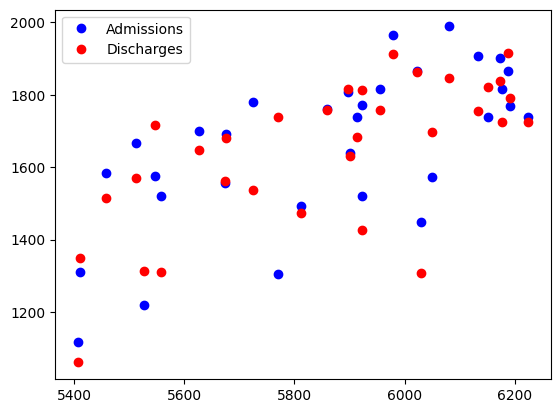

In [31]:
#plot the relationship between adp_ma2 and adp target variable to see if linear 
plt.plot(_30day_pop_tot['ADP'],_30day_pop_tot['admission_count'],'o',color = 'b',label = 'Admissions')
plt.plot(_30day_pop_tot['ADP'],_30day_pop_tot['discharge_count'],'o',color = 'r', label =  'Discharges')
plt.legend()
plt.show()

### Colinearity and correlational metrics

However, since we are most likely not using a decision tree regression for our final model we will need to consider multicolinearity as an issue with our regression model. Therefore we will measure the correlation between regressors and between the regressors and the target variable (ADP) to better understand which regressors should and should not be included in our final model.

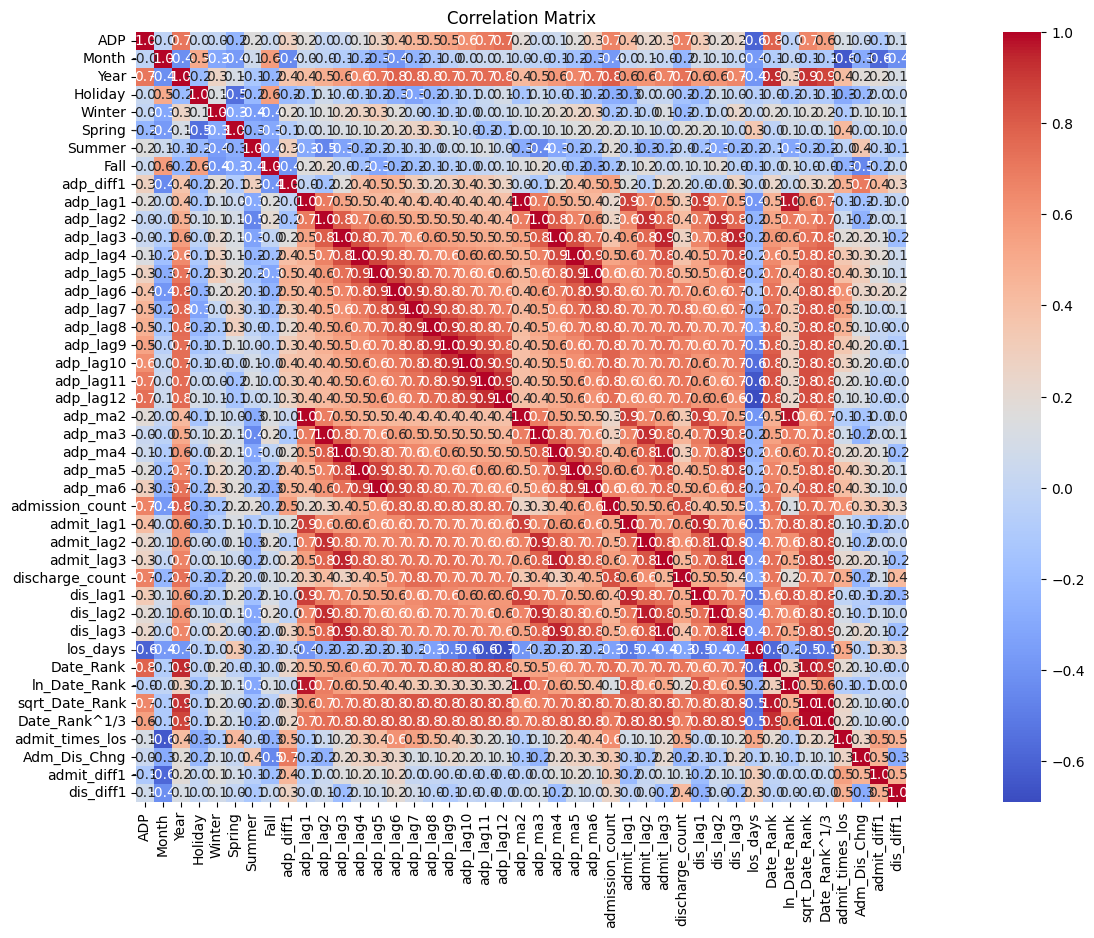

In [32]:
# Selecting only numerical columns
numerical_columns = _30day_pop_tot.select_dtypes(include=['float64', 'int64','int32'])

# Calculating correlation matrix
correlation_matrix = numerical_columns.corr()

# Plotting correlation matrix using seaborn
plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt="0.1f", square=True)
plt.title('Correlation Matrix')
plt.show()

According to Pressbooks chapter on [testing the significant of the correlation coefficient](https://pressbooks-dev.oer.hawaii.edu/introductorystatistics/chapter/testing-the-significance-of-the-correlation-coefficient/#:~:text=Compare%20r%20to%20the%20appropriate,use%20the%20line%20for%20prediction.), the reliability of the linear model also depends on how many observed data points are in the sample. We need to look at both the value of the correlation coefficient r and the sample size n, together. The [95% Critical Values of the Sample Correlation Coefficient Table](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/table-of-critical-values-pearson-correlation/) can be used to give you a good idea of whether the coefficient value is significant or not. Compare the coefficient to the appropriate critical value in the table. If the coefficeint is not between the positive and negative critical values, then the correlation coefficient is significant. If it is significant, then you may want to use the line for prediction.

Since we have 32 data points ($n$), the degrees of freedom for a two-tailed test is $n-2=30$. At a significance level of $\alpha = 0.05$, our critical values are $\pm 0.296$. Thus anything falling outside of that range can be used in our regression.

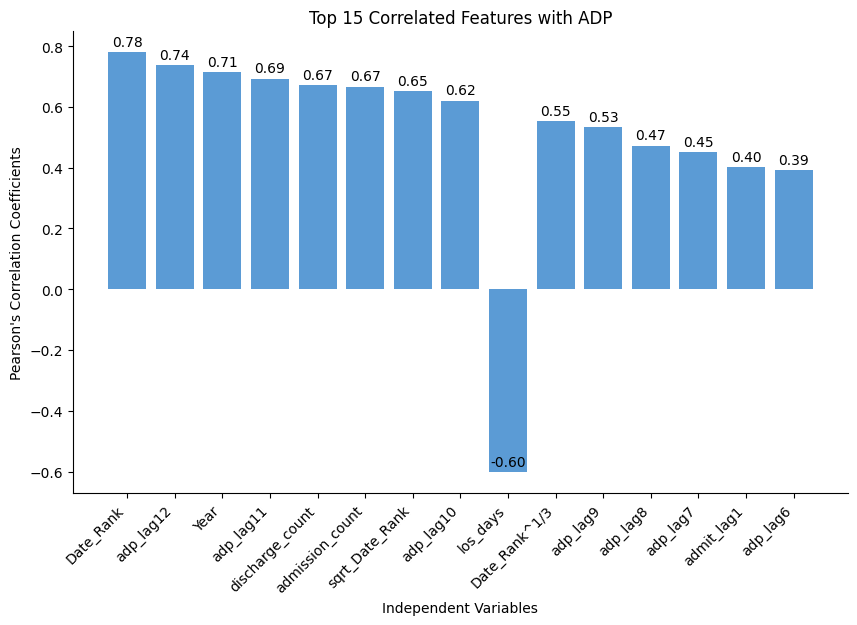

In [33]:
# Replace it with your actual correlation coefficients
correlation_coefficients = correlation_matrix['ADP'].iloc[1:]

# Take the absolute values of correlation coefficients and sort the indices accordingly
sorted_indices = correlation_coefficients.abs().sort_values(ascending=False).index

# Select the top 10 indices
top_10_indices = sorted_indices[:15]

# Extract the corresponding top 10 coefficients
top_10_coefficients = correlation_coefficients[top_10_indices]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_indices, top_10_coefficients, color=(91/255, 155/255, 213/255))

plt.xlabel('Independent Variables')
plt.ylabel("Pearson's Correlation Coefficients")
plt.title('Top 15 Correlated Features with ADP')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add text to each bar
for bar, coeff in zip(bars, top_10_coefficients):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{coeff:.2f}', 
             ha='center', va='bottom', color='black')
plt.savefig(r'C:\Users\emjoh\OneDrive\Documents\DCJ Analyses\DOC_Jail_Pop_Proj_Streamlit\static\top15_corr_ivs.png', bbox_inches = 'tight')
plt.show()

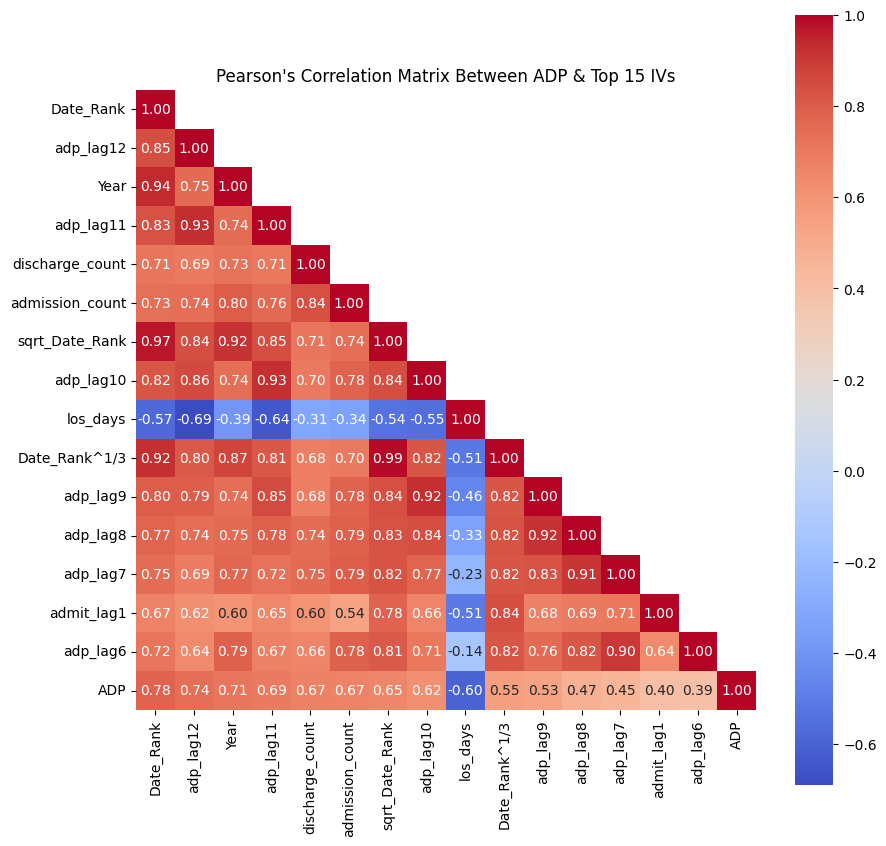

In [34]:
#print correlation matrix between the top 10 features
top_indices = sorted_indices[:15]
top_columns = _30day_pop_tot[top_indices.to_list()+['ADP']]

# Calculating correlation matrix
correlation_matrix = top_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plotting correlation matrix using seaborn with masked upper triangle
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt="0.2f", square=True, mask=mask)
plt.title("Pearson's Correlation Matrix Between ADP & Top 15 IVs")
plt.savefig(r'C:\Users\emjoh\OneDrive\Documents\DCJ Analyses\DOC_Jail_Pop_Proj_Streamlit\static\top15_multicol_ivs.png', bbox_inches = 'tight')
plt.show()

- admit_lag2 & Date_Rank have the top highest correlation coefficients with ADP, however, they are highly correlated with one another as well which is not ideal for a linear regression. Date_Rank is less correlated with admit_lag1 and admission_count, therefore we should use these instead of admit_lag2.

- Date_Rank and Year are too correlated with one another to use together in one Regression. We will use Date_Rank.

- Similarly, adp_lag11 and adp_lag12 are too correlated with one another. We will use adp_lag12 because given the monthly granularity of our data it makes most sense to use the ADP 12 months prior to predict current ADP.

- Admission and discharge counts are also correlated with one another, we should avoid using the two in a model together. Instead we could use dis_lag3 as there is more minimal colinearity between the variables. 

It is interested that neither adp_ma2 or adp_lag1 are among the top 15 IVs by correlation coefficient. This may indicate a non-linear relationship between the IV and DV that is being picked up in the random forest model.

### Regression Performance

Once we have decided which regressors to include in our model, we will train and test the model on our dataset to measure in and out of sample performance. We will compare the performance for the model trained on all the regressors and just the selected regressors decided after feature engineering to see which model is better suited to our use case.

3615.6181399507286 48.752427482566894
7184.163764346291 69.88592883635803
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     27.08
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           6.83e-08
Time:                        14:50:37   Log-Likelihood:                 29.816
No. Observations:                  25   AIC:                            -41.63
Df Residuals:                      16   BIC:                            -30.66
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

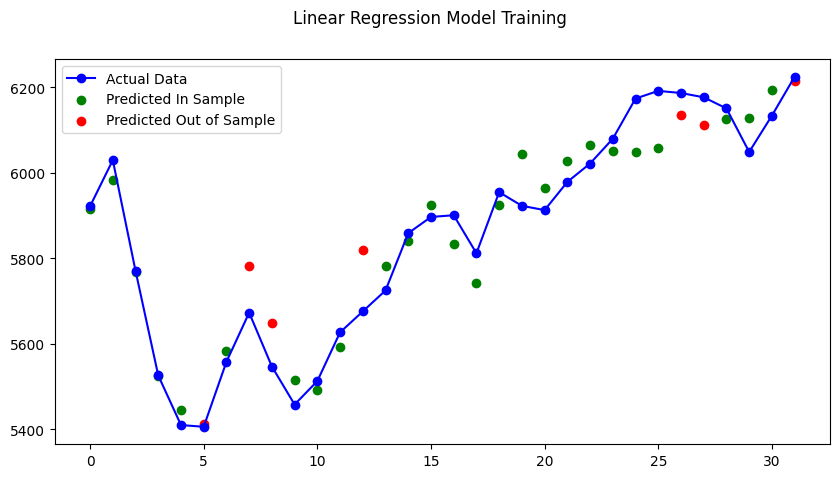

In [68]:
#linear regression with all regressors
regressor_ls = ['Date_Rank','admission_count','discharge_count','adp_lag8','adp_lag12', 'dis_lag1', 'dis_lag2','dis_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

14982.66753091506 84.03440589933649
16037.273178472029 115.00732499152726
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     9.535
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           0.000112
Time:                        14:51:39   Log-Likelihood:                 12.046
No. Observations:                  25   AIC:                            -12.09
Df Residuals:                      19   BIC:                            -4.778
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

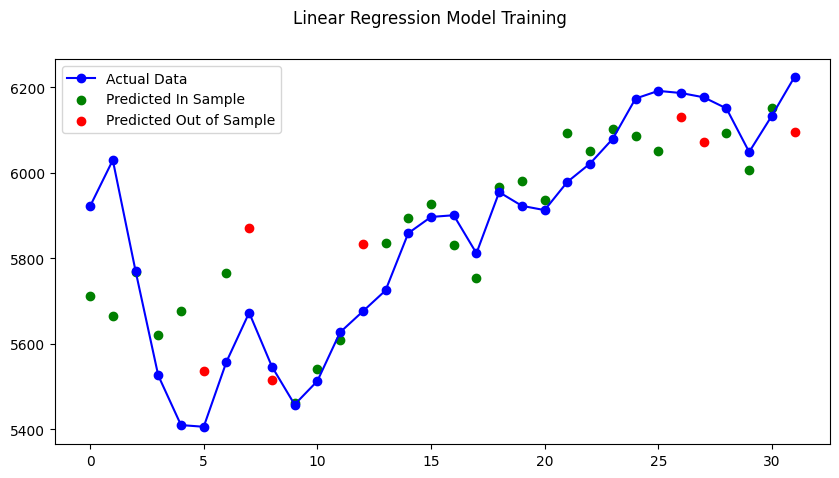

In [69]:
#see how the above model compares without Year variables
regressor_ls = ['Date_Rank','admission_count','discharge_count','adp_lag8','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

5831.570750825135 63.22938416258039
12310.159023816504 100.79896456681568
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     30.46
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.91e-08
Time:                        14:52:20   Log-Likelihood:                 23.841
No. Observations:                  25   AIC:                            -35.68
Df Residuals:                      19   BIC:                            -28.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

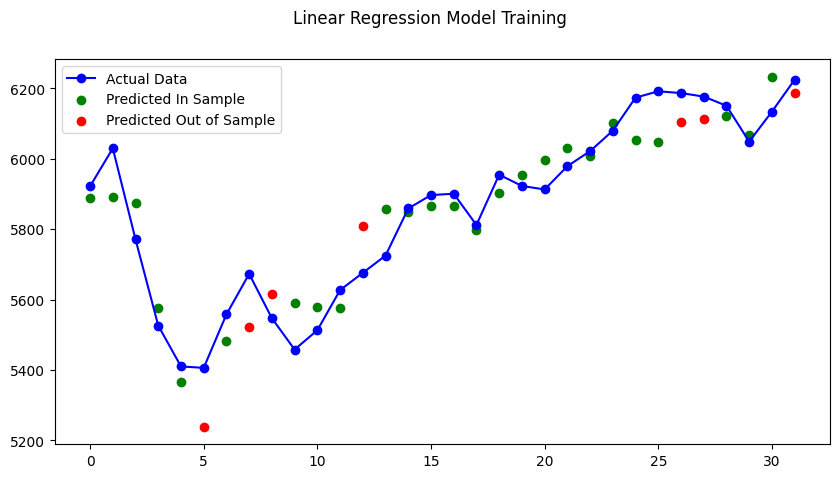

In [70]:
#see how the above model compares without Year variables
regressor_ls = ['Date_Rank','admission_count', 'dis_lag3','adp_lag4','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

8832.580772812214 71.63326378494777
5374.101951157035 61.33298340699951
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     24.76
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.67e-07
Time:                        14:52:43   Log-Likelihood:                 18.651
No. Observations:                  25   AIC:                            -27.30
Df Residuals:                      20   BIC:                            -21.21
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

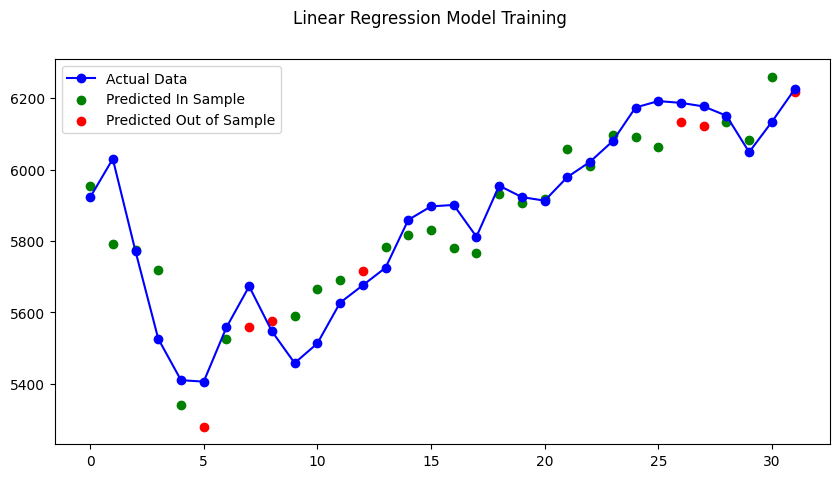

In [71]:
#see how the above model compares without adp_lag12 variable since its the only one above that isnt statistically sig a  = 0.05
regressor_ls = ['Date_Rank','admission_count', 'dis_lag1','adp_lag4']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

7717.224068259755 73.21730627522032
14667.788062809885 110.38639848779063
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     40.69
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           6.26e-09
Time:                        14:53:02   Log-Likelihood:                 20.339
No. Observations:                  25   AIC:                            -32.68
Df Residuals:                      21   BIC:                            -27.80
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

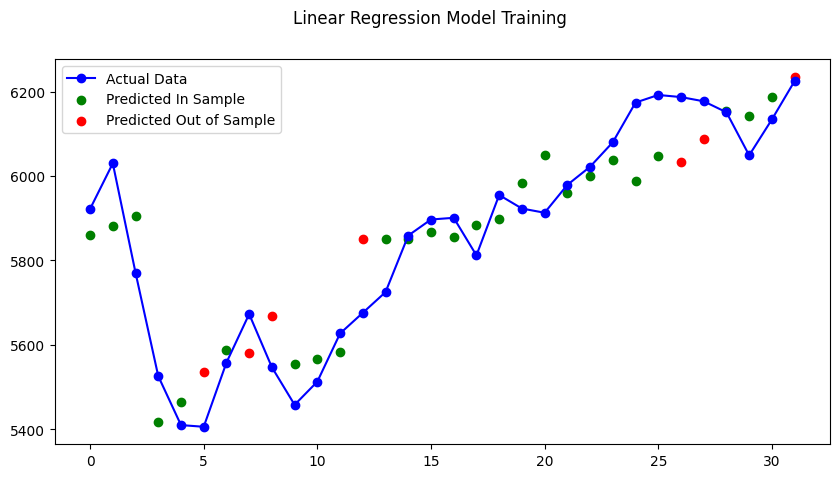

In [72]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank','adp_lag12','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

7855.162580545972 74.21899757720094
21781.88524509995 121.8012885350967
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     39.85
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           7.53e-09
Time:                        14:53:52   Log-Likelihood:                 20.117
No. Observations:                  25   AIC:                            -32.23
Df Residuals:                      21   BIC:                            -27.36
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

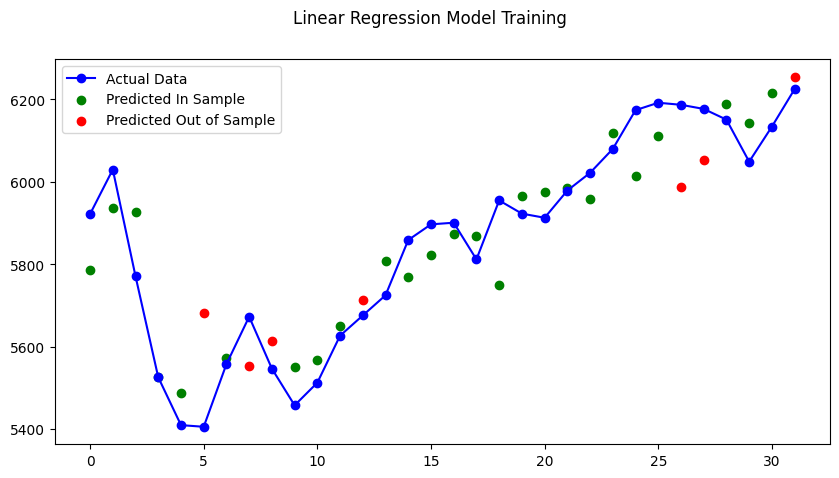

In [74]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank','los_days','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

11350.303362884559 87.36360985412718
25900.7858877033 137.3773739089802
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     25.43
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           3.46e-07
Time:                        14:54:49   Log-Likelihood:                 15.516
No. Observations:                  25   AIC:                            -23.03
Df Residuals:                      21   BIC:                            -18.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

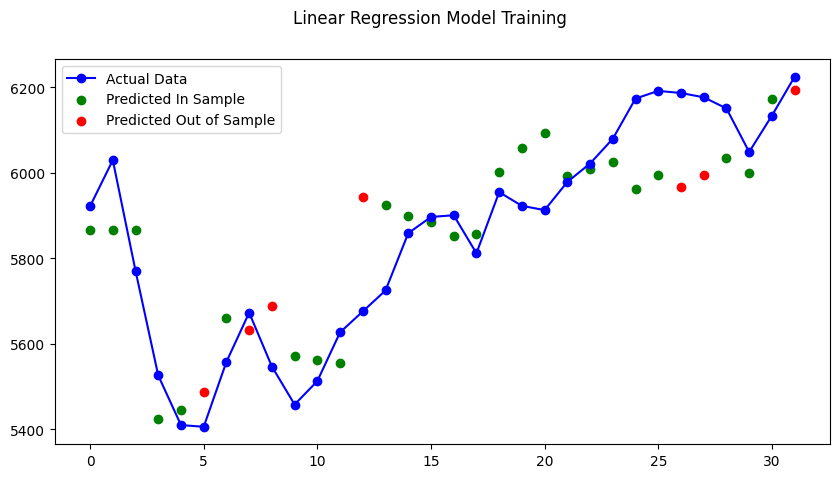

In [75]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Year','admit_lag3','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

19984.104128793533 122.12679593137734
38679.54061753792 176.29196650632665
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     11.42
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           0.000119
Time:                        14:55:03   Log-Likelihood:                 8.4450
No. Observations:                  25   AIC:                            -8.890
Df Residuals:                      21   BIC:                            -4.014
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

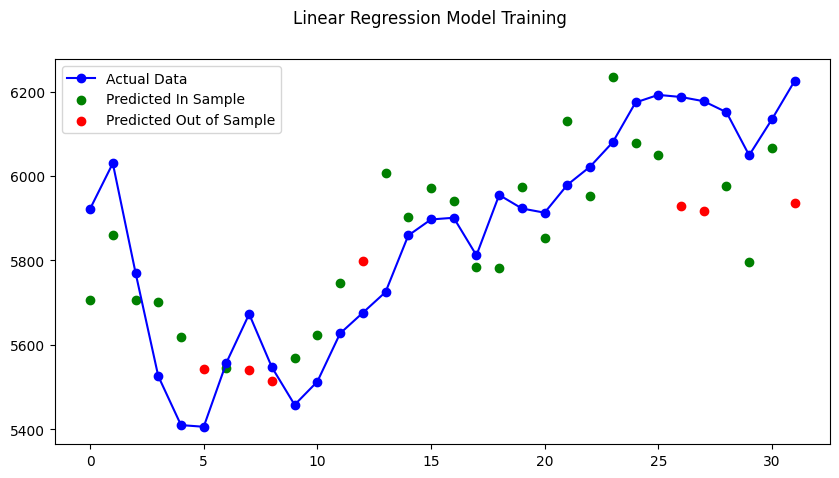

In [76]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['admission_count','los_days','adp_ma6']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

23701.660461900028 121.09371426656995
34368.7938856586 163.2648409264909
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     8.528
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           0.000675
Time:                        14:55:16   Log-Likelihood:                 6.3124
No. Observations:                  25   AIC:                            -4.625
Df Residuals:                      21   BIC:                            0.2507
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

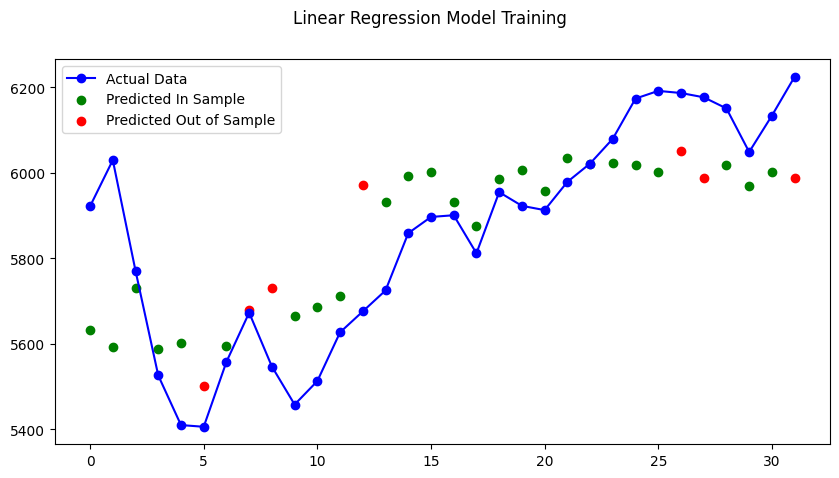

In [77]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['admission_count','discharge_count','adp_lag12']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

12489.458414507415 84.46584473289495
35192.529747020075 161.17630480301236
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     22.47
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           9.34e-07
Time:                        14:55:32   Log-Likelihood:                 14.321
No. Observations:                  25   AIC:                            -20.64
Df Residuals:                      21   BIC:                            -15.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

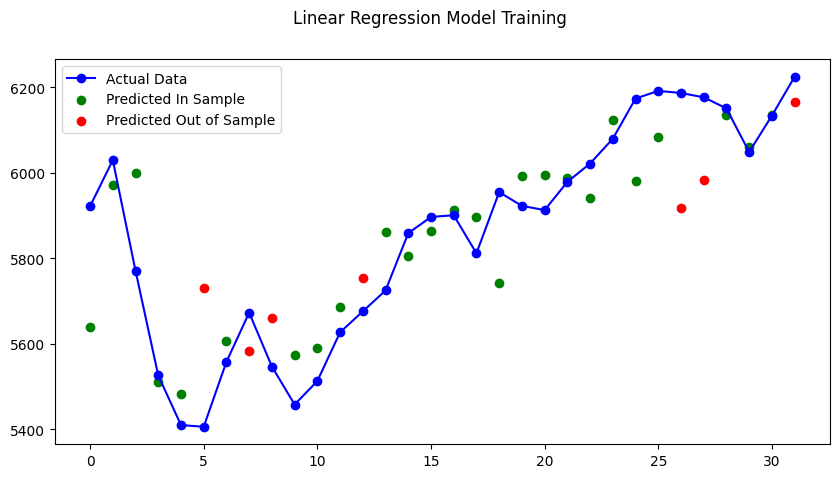

In [78]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','los_days','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

15482.089378491046 96.64312693278022
15605.370940657816 119.36832497628868
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     16.77
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           8.61e-06
Time:                        14:55:48   Log-Likelihood:                 11.636
No. Observations:                  25   AIC:                            -15.27
Df Residuals:                      21   BIC:                            -10.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

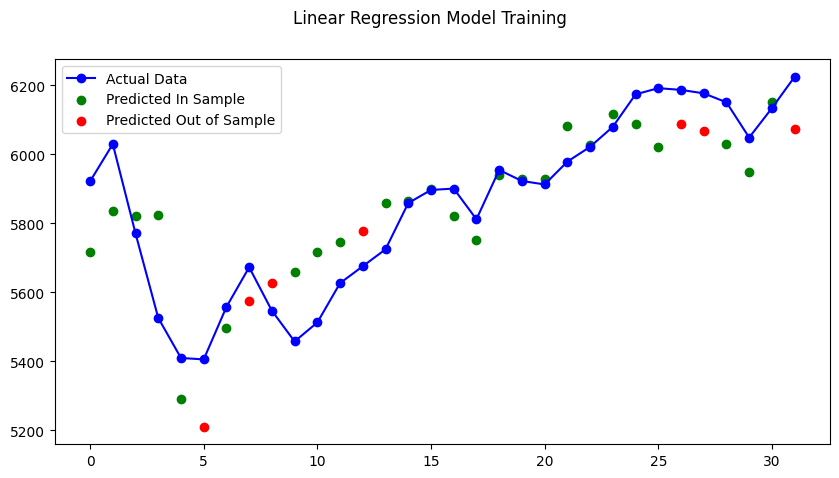

In [79]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

20610.24463911663 112.63654068280863
24759.245832097364 147.34957601693142
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     10.86
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           0.000163
Time:                        14:56:24   Log-Likelihood:                 8.0593
No. Observations:                  25   AIC:                            -8.119
Df Residuals:                      21   BIC:                            -3.243
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

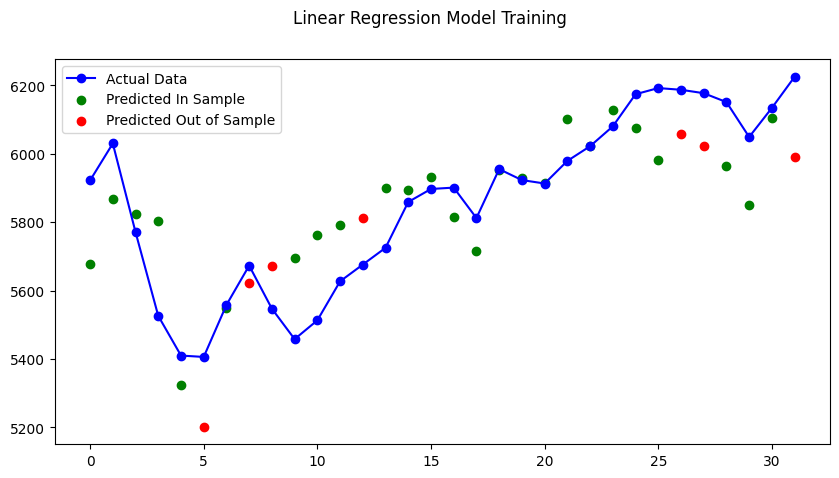

In [81]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['Date_Rank^1/3','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

15482.089378491046 96.64312693278022
15605.370940657816 119.36832497628868
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     16.77
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           8.61e-06
Time:                        14:56:52   Log-Likelihood:                 11.636
No. Observations:                  25   AIC:                            -15.27
Df Residuals:                      21   BIC:                            -10.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

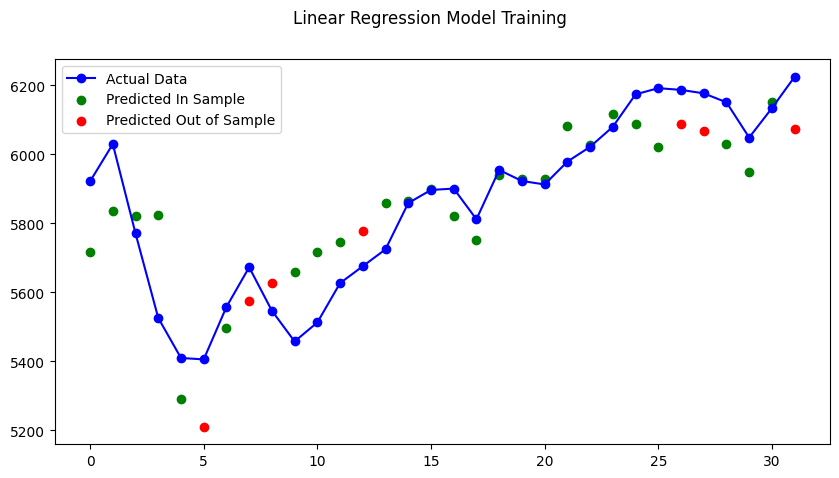

In [82]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admission_count']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

14783.970448898703 94.02578740075339
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     30.68
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           5.41e-09
Time:                        14:57:10   Log-Likelihood:                 15.632
No. Observations:                  32   AIC:                            -23.26
Df Residuals:                      28   BIC:                            -17.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sqrt_

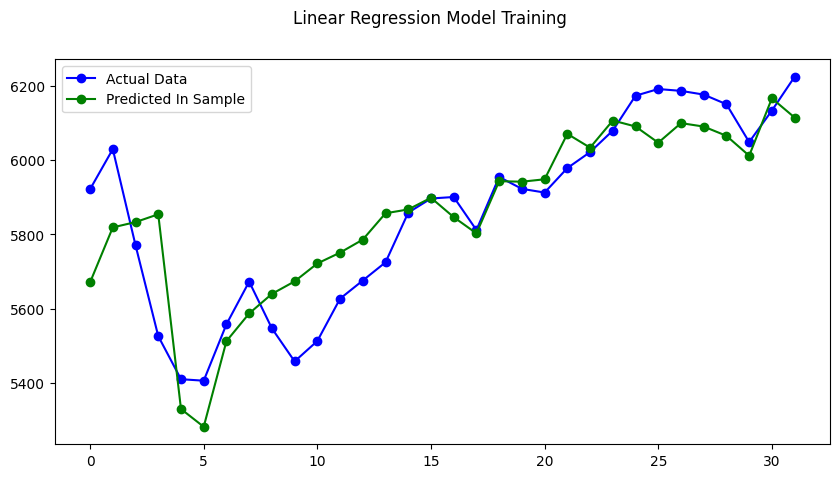

In [83]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admission_count']
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP'] + regressor_ls]
data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

#train and test
# Fit the linear regression model on the entire dataset
model = sm.OLS(y, X).fit()

# Make in sample predictions
IS_pred = model.predict(X)

#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X_train.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)

#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(data['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(data['ADP'], IS_inputs[:,0])

print(IS_mse, IS_mae)
print(model.summary())

fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Model Training')

actual, = plt.plot(data.index,data['ADP'], 'bo-', label='Actual Data')
predicted_IS, = plt.plot(data.index, IS_inputs[:,0], 'go-', label='Predicted In Sample')

plt.legend(handles=[actual,predicted_IS])
plt.show()

13848.742663161433 93.56589700439719
12175.256870666768 93.2220601465073
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     19.58
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           2.72e-06
Time:                        14:57:39   Log-Likelihood:                 13.029
No. Observations:                  25   AIC:                            -18.06
Df Residuals:                      21   BIC:                            -13.18
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

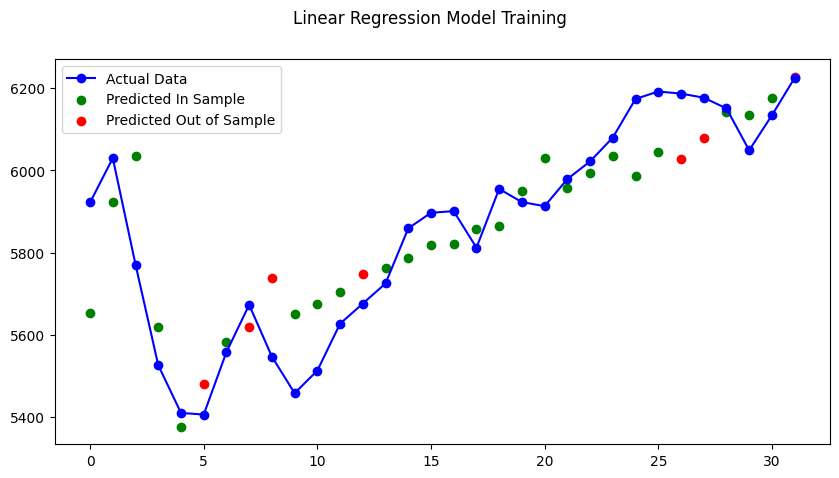

In [84]:
#see how the above model compares without dis_lag1 variable since highly corr with the Date_Rank and admission_count variable
regressor_ls = ['sqrt_Date_Rank','adp_lag4','admit_lag3']
model, IS_mae, OS_mea = train_test_MLR(_30day_pop_tot,'ADP', regressor_ls, test_size = 0.2, random_state = 123)

These results are promising. Below find the model performance results by input regressor:


| Regressors | $R^2$ | In Sample MAE | Out of Sample MAE|Significance $\alpha$ = 0.05|
|------------|-------|---------------|------------------|------------|
|['Year','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.810 | 75.82 | 190.5 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.888 | 58.80 | 83.02 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4'] | 0.872 | 59.77 | 98.85 |Yes|
|['Date_Rank','adp_lag4','admission_count']|0.802|70.38|63.58|Yes|
|['sqrt_Date_Rank','adp_lag4','admit_lag3']|0.759|86.49|85.86|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.690|93.97|178.8|No|

Considerations:

- small sample size: Due to the small sample sizes during model fit, it is difficult to definitely deduce statistically significant relationships between DV and IVs. We should limit the number of regressors and therefore pick the models with a maximum of three IVs.

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] has the rightest r-square value. This is probably due to overfitting (which you can see based on the increased out of sample error) and therefore we will not pick this model. 

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'adp_lag4'] has the lowest out of sample average absolute error. I am willing to compromise for the decreased in sample performance as compared to the other models as it ensures we are not overfitting to our training data. However, since we do not know the admission count for the next 12 timestamps, we will also need to predict this in order to predict ADP using the regression model.

- I also lean towards using the model with input variables of ['sqrt_Date_Rank','adp_lag4','admit_lag3'] despite the r-square and out of sample MAE not being optimal because I know that the relationship between time and ADP is not fully linear. There is an absolute maximum number of individuals that can be in DOC custody therefore using a non-linear variable makes the most sense as we increase the size of our data sample. This method also forces us to have to predict admission counts into the future but since we will be using the third time lag of admission rates, the first three data points of our prediction will be more accurate than the model mentioned in the above bullet since these are observable values as opposed to predictions.